# Isochrone analysis
Note that the API key has a 20 call/minute and 500 call/day limit

In [51]:
# imports
from shapely import Point
from shapely import intersects, difference
from shapely.geometry import shape, mapping
import matplotlib.pylab as plt
import numpy as np
import fiona
import pyproj
from shapely.ops import transform
import requests
import json
import pyproj

In [33]:
# user inputs 
population_fn = "tl_2020_08_tabblock20/tl_2020_08_tabblock20_26913.shp"
center = Point(499949.3,4400390.4) # utm13N
num_bins = 100 # number of steps between zero and max_dist
request_isochrone = False

In [34]:
# Isochrone request
# Commented out by default
body = {"locations":[[-105.00012985139018,39.7531028840525]],"range":[3600],"attributes":["area"],"interval":360,"range_type":"time", "area_units":"km"}
# Latitude in EPSG:4326
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf624873ff41f6e4a546c8b32558e1e3c9b986',
    'Content-Type': 'application/json; charset=utf-8'
}
if request_isochrone:
    call = requests.post('https://api.openrouteservice.org/v2/isochrones/driving-car', json=body, headers=headers)

print(call.status_code, call.reason)
print(call.text)

200 OK
{"type":"FeatureCollection","metadata":{"attribution":"openrouteservice.org | OpenStreetMap contributors","service":"isochrones","timestamp":1711931325360,"query":{"profile":"driving-car","locations":[[-105.00012985139018,39.7531028840525]],"range":[3600.0],"range_type":"time","area_units":"km","attributes":["area"],"interval":360.0},"engine":{"version":"7.1.1","build_date":"2024-01-29T14:41:12Z","graph_date":"2024-03-24T16:02:19Z"}},"bbox":[-105.765089,39.014323,-104.044296,40.571389],"features":[{"type":"Feature","properties":{"group_index":0,"value":360.0,"center":[-104.9997372005485,39.75280276039596],"area":22.51711807},"geometry":{"coordinates":[[[-105.028249,39.74136],[-105.028035,39.738614],[-105.026869,39.738614],[-105.017645,39.731615],[-105.017564,39.730786],[-105.017146,39.729751],[-105.013738,39.730911],[-105.002966,39.730844],[-105.000421,39.728716],[-104.992243,39.72811],[-104.990406,39.728126],[-104.990219,39.728207],[-104.981939,39.73336],[-104.978731,39.735442]

In [110]:
features_json = json.loads(call.text)['features']
len(features_json)

10

In [111]:
# TODO: Build shells and circles out of isochrones
# Transform..."circles"?
circles_4326 = [shape(f['geometry']) for f in features_json]

project = pyproj.Transformer.from_proj(
    pyproj.Proj('epsg:4326'), # source coordinate system
    pyproj.Proj('epsg:32613'), always_xy=True) # destination coordinate system
circles = [transform(project.transform, c) for c in circles_4326 ]


shells = [circles[0]] # Init with inner isochrone

for i in range(len(circles) - 1):
    isochrone_shell = difference(shape(circles[i+1]),shape(circles[i]))
    shells.append(isochrone_shell)

In [113]:
print(f"lengths: {len(shells)} | {len(circles)}")

lengths: 10 | 10


In [114]:
# print(circles[0])

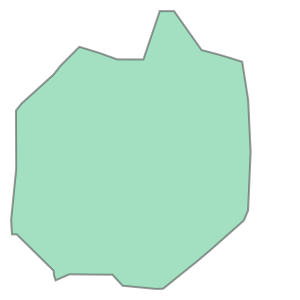

In [115]:
circles[0]

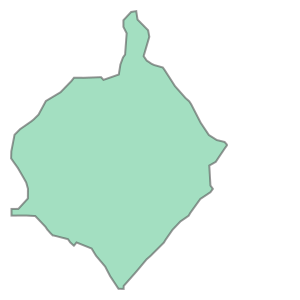

In [116]:
circles[1]

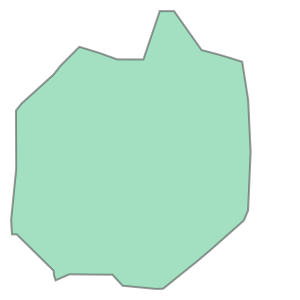

In [117]:
shells[0]

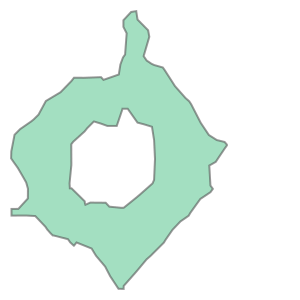

In [118]:
shells[1]

In [119]:
# make radii, open population shapefile
with fiona.open(population_fn) as col:
    info = [(shape(feat['geometry']), feat['properties']['POP20']) for feat in col]


In [120]:
population = [np.nan]
cumulative_population = [0]
avg_population_density = [np.nan]
shell_population_density =[np.nan]
total_area = [0]
shell_area = [0]
# circles = [None] + circles
# shells = [None] + shells

for i in range(len(shells)):
# for i, r in enumerate(rs[1:]):

    # buffer point
    # buffered = center.buffer(r)
    buffered = circles[i]
    shell = shells[i]
    
    # # construct the shell between the two radii
    # if i>0:
    #     shell = buffered.difference(circles[-1])
    # else:
    #     shell = buffered
    
    # # store geometry
    # circles.append(buffered)
    # shells.append(shell)
    
    # store areas
    total_area.append(buffered.area)
    shell_area.append(shell.area)
    
    # determine population in this shell
    pop = 0
    for shp, shp_pop in info:
        if intersects(shell, shp):      
            fraction = shell.intersection(shp).area/shp.area     
            pop += fraction*shp_pop
    
    # store populations
    population.append(pop)
    cumulative_population.append(cumulative_population[-1]+pop)
    
    # calculate population density
    avg_population_density.append(cumulative_population[-1]/total_area[-1])
    shell_population_density.append(pop/shell.area)
    
    print(f'SHELL {i}, cumulative pop: {cumulative_population[-1]}')

SHELL 0, cumulative pop: 89082.64418735036
SHELL 1, cumulative pop: 296034.20767700823
SHELL 2, cumulative pop: 685463.8781175911
SHELL 3, cumulative pop: 1288842.8881202573
SHELL 4, cumulative pop: 2057728.603498967
SHELL 5, cumulative pop: 2690934.590914587
SHELL 6, cumulative pop: 3009042.2080267384
SHELL 7, cumulative pop: 3193730.2824240183
SHELL 8, cumulative pop: 3304653.937197574
SHELL 9, cumulative pop: 3431635.0347317103


In [100]:
len(avg_population_density)

11

## Plots

In [121]:
rs = np.linspace(0, 360.*10, num=11)
rs

array([   0.,  360.,  720., 1080., 1440., 1800., 2160., 2520., 2880.,
       3240., 3600.])

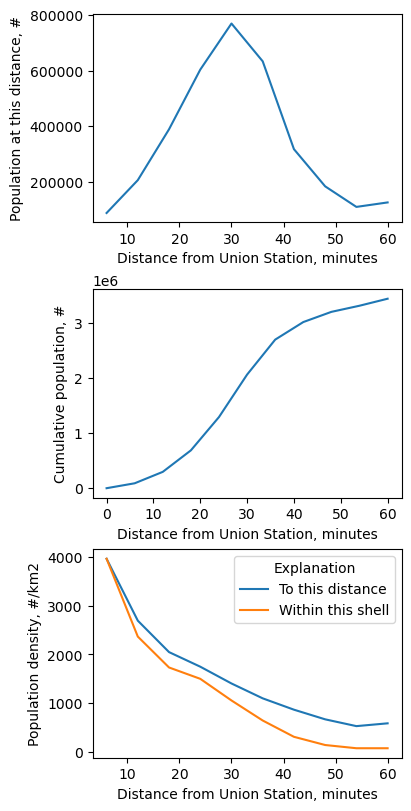

In [124]:
fig, axes = plt.subplots(figsize=(4,8),ncols=1, nrows=3, dpi=100, layout='constrained')

axes[0].plot(rs/60, population)
axes[0].set_xlabel("Distance from Union Station, minutes")
axes[0].set_ylabel("Population at this distance, #")

axes[1].plot(rs/60, cumulative_population)
axes[1].set_xlabel("Distance from Union Station, minutes")
axes[1].set_ylabel("Cumulative population, #")

axes[2].plot(rs/60, np.array(avg_population_density)*1e6, label ='To this distance')
axes[2].plot(rs/60, np.array(shell_population_density)*1e6, label="Within this shell")
axes[2].legend(title='Explanation')
axes[2].set_xlabel("Distance from Union Station, minutes")
axes[2].set_ylabel("Population density, #/km2")
fig.savefig("summary.png", dpi=300)

## Export

In [123]:
with fiona.open(population_fn) as src:
    driver = src.driver
    crs = src.crs
    
schema = {'geometry': 'Polygon',
 'properties': {'pop': 'float',
                'density': 'float',
}}
# shell density
with fiona.open("shells_60min.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for i in range(len(shells)):
        feat = {'geometry':mapping(shells[i]),
                'properties':{'pop':population[i+1],
                            'density': shell_population_density[i+1]*1e6}}

        dst.write(feat)
        
# selected tracts, write out density
selection = center.buffer(75000)   
with fiona.open("tract_density_60min.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for shp, shp_pop in info:
        if intersects(selection,shp):
            feat = {'geometry':mapping(shp),
                'properties':{'pop':shp_pop,
                            'density': shp_pop/shp.area*1e6}}
            dst.write(feat) 
            

11